<a href="https://colab.research.google.com/github/FatemeFarhang/data-science/blob/main/Task_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For more convenience, I switched my data to random tweets to include reply and like counts as well as retweet counts.

## Import data and inquiries

### Libraries

In [1]:
# DataFrame
import pandas as pd
pd.set_option("max_colwidth", 200)

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# # Scikit-learn
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.manifold import TSNE
# from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import time
import pickle
import itertools
from datetime import datetime, timedelta


### Import Data

In [34]:
url = "https://github.com/sraeisi/MachineLearning_Physics/blob/master/Data/random_tweets.csv?raw=true"
df = pd.read_csv(url,
                 usecols = [2,6,7,10,11,15,16,17]
                 )
df = df[df['language']=='en'].drop(['language'], axis=1)
df.drop_duplicates(ignore_index=True, inplace=True)
# df = df.sample(random_state=0, frac= .5, ignore_index = True)

print(f'There are a total number of {len(df)} tweets in this dataset.')
df.head()


There are a total number of 17513 tweets in this dataset.


,created_at,user_id,username,tweet,replies_count,retweets_count,likes_count
0,2021-10-02 23:59:59 UTC,1127431975520882688,maudi63,"@Timodc I just looked up where he grew up. Lowell, Massachusetts. I live near there now. My 3 kids all got their degrees the same place as him, UMass Lowell. There were lots of ‘tough towns’ in MA...",28,13,214
1,2021-10-02 23:59:58 UTC,793331593,tee_asz,Good morning to the ICAC commissioners in NSW who were doing the job they were tasked to do and enforcing the rule of law.,7,107,584
2,2021-10-02 23:59:58 UTC,386317180,swtlovex,U see some of us that can’t dance just like Whitemoney? U have no idea how we dance beautifully in our heads. The only problem is the execution in real steps,8,10,41
3,2021-10-02 23:59:56 UTC,1264612627516293121,kiergzn_,Thank you for all the killings and making the country more divided EVER in history. #SalamatPRRD,5,17,125
4,2021-10-02 23:59:56 UTC,265209421,mewiyev,the bookworm swordsman #Xingqiu #GenshinImapct https://t.co/OpVuz7rAG6,1,101,534


In [36]:
# convert time
df['created_at'] = [datetime.strptime(df.iloc[i]['created_at'], "%Y-%d-%m %H:%M:%S %Z") for i in range(len(df))]

# First Metric | Average Interactions per Post

In [54]:
users = df.user_id.unique()

# no. of posts of each user
for u in users:
    df.loc[df['user_id']== u,'n_posts'] = len(df[df['user_id']== u])

In [38]:
df['avg_int'] = 0

# average interactions per post
# tweets = df['tweet']
for i,r in df.iterrows():
    row = df.at[i, 'tweet']
    sub_df = df[df['tweet'] == row]
    origin = df.index[(df['tweet']==row) & (df['created_at']==min(sub_df['created_at']))][0] #the original tweet index
    if ( abs(sub_df['created_at'].diff()) ).sum() < timedelta(hours = 4): #only take into account the tweets that are created within approximately 2 hours
        n_int = 0
        n_int = n_int + sum(sub_df['likes_count'] + sub_df['retweets_count'] + sub_df['replies_count'])
        df.at[origin,'avg_int'] = ( n_int / df.at[origin, 'n_posts'] )
    else:
        n_int = 0
        n_int = n_int + sum(df.at[origin, 'likes_count'] + df.at[origin, 'retweets_count'] + df.at[origin,'replies_count'])
        df.at[origin,'avg_int'] = ( n_int / df.at[origin, 'n_posts'] )



In [53]:
df.head(5)

,created_at,user_id,username,tweet,replies_count,retweets_count,likes_count,n_posts,avg_int
0,2021-02-10 23:59:59,1127431975520882688,maudi63,"@Timodc I just looked up where he grew up. Lowell, Massachusetts. I live near there now. My 3 kids all got their degrees the same place as him, UMass Lowell. There were lots of ‘tough towns’ in MA...",28,13,214,1.0,255
1,2021-02-10 23:59:58,793331593,tee_asz,Good morning to the ICAC commissioners in NSW who were doing the job they were tasked to do and enforcing the rule of law.,7,107,584,1.0,698
2,2021-02-10 23:59:58,386317180,swtlovex,U see some of us that can’t dance just like Whitemoney? U have no idea how we dance beautifully in our heads. The only problem is the execution in real steps,8,10,41,1.0,59
3,2021-02-10 23:59:56,1264612627516293121,kiergzn_,Thank you for all the killings and making the country more divided EVER in history. #SalamatPRRD,5,17,125,1.0,147
4,2021-02-10 23:59:56,265209421,mewiyev,the bookworm swordsman #Xingqiu #GenshinImapct https://t.co/OpVuz7rAG6,1,101,534,1.0,636


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feee717af90>,
      dtype=object)

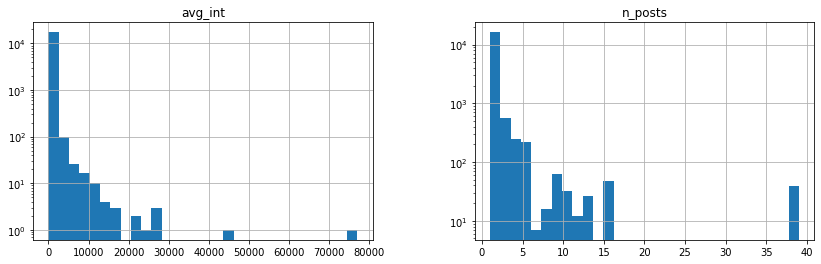

In [60]:
df.hist(['avg_int','n_posts'],bins=30, log=True, figsize=(14,4))

# Second Metric | Passion Point

For this part we need to label positive and negative tweets. <br/>
Since _emojis_ are the most common seperators of negative and positive tweets, I will annotate the dataset mainly based on those in my first attempt.

In [80]:
for i,r in df.iterrows():
    for word in df.at[i,'tweet'].lower().split(" "):
        # positive
        if word in[':)', ':p', ':d', ':-)', ':))', 'love', 'great', 'thanks', 'thank', 'happy', 'nice', 'good', 'love', 'awesome', '&lt;3', 'follow']:
            df.at[i, 'semantic'] = int(1)
        # negative
        elif word in[':(((', ':((', ':(', ':-(', 'sad', 'miss', 'sorry']:
            df.at[i, 'semantic'] = int(0)
        else:
            df.at[i, 'semantic'] = int(0)

print(f'Total number of tweets annonated as positive = {df.semantic.sum()}')

Total number of tweets annonated as positive = 66.0


So, this annotation is likely to be biased since it considers only a few expressions. <br/>
Therefore I will use **transfer learning** to annotate tweets.

### Download saved model

In [94]:
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive"
if os.path.isdir('~/.kaggle')==0:
    os.makedirs('~/.kaggle')
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# download saved model
!kaggle kernels output paoloripamonti/twitter-sentiment-analysis

Output file downloaded to /content/encoder.pkl
Output file downloaded to /content/model.h5
Output file downloaded to /content/model.w2v
Output file downloaded to /content/tokenizer.pkl
Kernel log downloaded to /content/twitter-sentiment-analysis.log 


## Pre-Process dataset

In [101]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
%%time
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
df_doc = df.tweet.apply(lambda x: preprocess(x))

CPU times: user 1.22 s, sys: 5.66 ms, total: 1.23 s
Wall time: 1.23 s


In [104]:
%%time
documents = [_text.split() for _text in df_doc] 

CPU times: user 43.1 ms, sys: 13.2 ms, total: 56.3 ms
Wall time: 102 ms


## Word2Vec

In [113]:
#load the model
w2v_model = gensim.models.word2vec.Word2Vec.load("model.w2v")

In [114]:
w2v_model.build_vocab(documents, update= True)

In [124]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size =", vocab_size)

Vocab size = 30577


In [117]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

CPU times: user 34.8 s, sys: 235 ms, total: 35 s
Wall time: 18.8 s


(6141493, 7290752)

In [123]:
w2v_model.wv.most_similar("nice", topn=15)

[('lovely', 0.4983063340187073),
 ('great', 0.4413699507713318),
 ('cool', 0.3828105628490448),
 ('wonderful', 0.3778040409088135),
 ('fab', 0.36366233229637146),
 ('fantastic', 0.35376614332199097),
 ('fancy', 0.32479211688041687),
 ('gorgeous', 0.3220602571964264),
 ('pleasant', 0.31885385513305664),
 ('beautiful', 0.3147013783454895),
 ('lush', 0.31272709369659424),
 ('nicer', 0.29557162523269653),
 ('pleased', 0.2856575846672058),
 ('nicely', 0.28565528988838196),
 ('awesome', 0.28550511598587036)]

# Third Metric | Content Creation

In order to find the number of positine words in tweets, it's helpful to find the word similarities to positive words in tweets.